In [1]:
import os, shutil, math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from tabulate import tabulate
from datetime import datetime, timedelta
from fastai.tabular.core import add_datepart

# Seaborn style settings
# sns.set_theme(style = "ticks", palette = 'dark:salmon_r')
sns.set_theme(style = "ticks", palette = 'mako')

In [2]:
!git clone "https://github.com/erich-hs/Air-We-Breath"

Cloning into 'Air-We-Breath'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 16 (delta 2), reused 16 (delta 2), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [3]:
# Master datasets paths
paths = glob('Air-We-Breath/data/*.csv')

# Reading master datasets
datasets = {}
for path in paths:
  ds = str(path[19:-4])
  datasets[ds] = pd.read_csv(path)
  # Converting datetime column
  datasets[ds]['DATE_PST'] = pd.to_datetime(datasets[ds]['DATE_PST'])
  # Creating datepart features
  datasets[ds] = add_datepart(datasets[ds], 'DATE_PST',
                              drop = False, prefix = '', time = True)
  datasets[ds].drop(['Is_month_end', 'Is_month_start', 'Is_quarter_end',
                     'Is_quarter_start', 'Is_year_end', 'Is_year_start',
                     'Elapsed', 'Minute', 'Second'],
                    axis = 1, inplace = True)
  
datasets_list = sorted(list(datasets.keys()))
datasets_list

['North_Vancouver_Mahon_Park',
 'North_Vancouver_Second_Narrows',
 'Vancouver_Clark_Drive',
 'Vancouver_International_Airport_#2']

In [4]:
# Dataset dimensions
for dataset in datasets_list:
  print(f"{datasets[dataset].shape} dim. for {dataset} dataset.")

(57014, 9) dim. for North_Vancouver_Mahon_Park dataset.
(57014, 9) dim. for North_Vancouver_Second_Narrows dataset.
(57014, 9) dim. for Vancouver_Clark_Drive dataset.
(57014, 9) dim. for Vancouver_International_Airport_#2 dataset.


In [5]:
print(tabulate(datasets['North_Vancouver_Mahon_Park'].head(), headers = 'keys', tablefmt = 'psql'))

+----+---------------------+-------------+--------+---------+--------+-------+-------------+-------------+--------+
|    | DATE_PST            |   RAW_VALUE |   Year |   Month |   Week |   Day |   Dayofweek |   Dayofyear |   Hour |
|----+---------------------+-------------+--------+---------+--------+-------+-------------+-------------+--------|
|  0 | 2016-01-01 01:00:00 |    22.7989  |   2016 |       1 |     53 |     1 |           4 |           1 |      1 |
|  1 | 2016-01-01 02:00:00 |    22.9091  |   2016 |       1 |     53 |     1 |           4 |           1 |      2 |
|  2 | 2016-01-01 03:00:00 |    19.8577  |   2016 |       1 |     53 |     1 |           4 |           1 |      3 |
|  3 | 2016-01-01 04:00:00 |    13.576   |   2016 |       1 |     53 |     1 |           4 |           1 |      4 |
|  4 | 2016-01-01 05:00:00 |     7.07959 |   2016 |       1 |     53 |     1 |           4 |           1 |      5 |
+----+---------------------+-------------+--------+---------+--------+--

In [6]:
# Looking for negative PM 2.5 values
for dataset in datasets_list:
  print(min(datasets[dataset]['RAW_VALUE']))

0.0
nan
-0.6341805
0.0


In [7]:
datasets['Vancouver_Clark_Drive'][datasets['Vancouver_Clark_Drive']['RAW_VALUE'] < 0]

,DATE_PST,RAW_VALUE,Year,Month,Week,Day,Dayofweek,Dayofyear,Hour
19874,2018-04-08 03:00:00,-0.028597,2018,4,14,8,6,98,3
51793,2021-11-28 02:00:00,-0.320931,2021,11,47,28,6,332,2
51794,2021-11-28 03:00:00,-0.604097,2021,11,47,28,6,332,3
51795,2021-11-28 04:00:00,-0.634181,2021,11,47,28,6,332,4
51796,2021-11-28 05:00:00,-0.438903,2021,11,47,28,6,332,5
51800,2021-11-28 09:00:00,-0.091346,2021,11,47,28,6,332,9
54003,2022-02-28 04:00:00,-0.030625,2022,2,9,28,0,59,4


In [8]:
# Setting negative values a NaN
for dataset in datasets_list:
  datasets[dataset][datasets[dataset]['RAW_VALUE'] < 0] = math.nan

## Visualizing missing values
* How missing values are plotted with standard visualizations

In [9]:
# Missing value section
subset = datasets['North_Vancouver_Mahon_Park'][
                     (datasets['North_Vancouver_Mahon_Park']['DATE_PST'] >= datetime(2016, 3, 22, 18)) &
                     (datasets['North_Vancouver_Mahon_Park']['DATE_PST'] <= datetime(2016, 3, 24, 18))
                 ]

print(tabulate(subset, headers = 'keys', tablefmt = 'psql'))

+------+---------------------+-------------+--------+---------+--------+-------+-------------+-------------+--------+
|      | DATE_PST            |   RAW_VALUE |   Year |   Month |   Week |   Day |   Dayofweek |   Dayofyear |   Hour |
|------+---------------------+-------------+--------+---------+--------+-------+-------------+-------------+--------|
| 1961 | 2016-03-22 18:00:00 |    2.29019  |   2016 |       3 |     12 |    22 |           1 |          82 |     18 |
| 1962 | 2016-03-22 19:00:00 |    1.91071  |   2016 |       3 |     12 |    22 |           1 |          82 |     19 |
| 1963 | 2016-03-22 20:00:00 |    2.72774  |   2016 |       3 |     12 |    22 |           1 |          82 |     20 |
| 1964 | 2016-03-22 21:00:00 |    1.96188  |   2016 |       3 |     12 |    22 |           1 |          82 |     21 |
| 1965 | 2016-03-22 22:00:00 |    1.48958  |   2016 |       3 |     12 |    22 |           1 |          82 |     22 |
| 1966 | 2016-03-22 23:00:00 |    1.04685  |   2016 |   

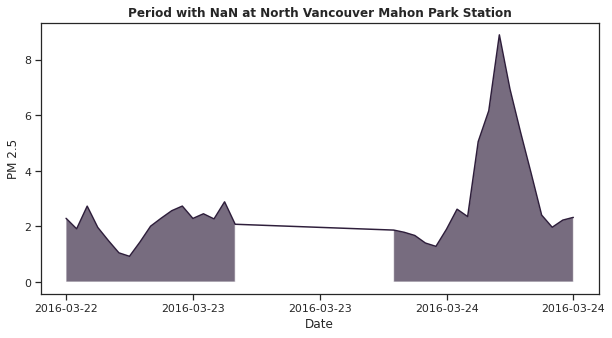

In [10]:
# Standard visualization with seaborn lineplot
plt.figure(figsize = (10, 5))

# Lineplot
l = sns.lineplot(x = 'DATE_PST', y = 'RAW_VALUE', data = subset)
# Filling values to indicate NaN
l.fill_between(x = 'DATE_PST', y1 = 'RAW_VALUE', data = subset, alpha = 0.65)
l.set_title("Period with NaN at North Vancouver Mahon Park Station",
            fontsize = 12, fontweight = 'bold')
l.set_ylabel("PM 2.5")
l.set_xlabel("Date")
l.set_xticks(l.get_xticks()[::2])
plt.show()

In [11]:
# Dummy variable to keep track of missing samples and missing sample length
for dataset in datasets_list:
  datasets[dataset]['MISSING'] = np.where(datasets[dataset]['RAW_VALUE'].isnull(), 1, 0)

datasets['North_Vancouver_Mahon_Park'].head()

,DATE_PST,RAW_VALUE,Year,Month,Week,Day,Dayofweek,Dayofyear,Hour,MISSING
0,2016-01-01 01:00:00,22.798870,2016.0,1.0,53.0,1.0,4.0,1.0,1.0,0
1,2016-01-01 02:00:00,22.909090,2016.0,1.0,53.0,1.0,4.0,1.0,2.0,0
2,2016-01-01 03:00:00,19.857730,2016.0,1.0,53.0,1.0,4.0,1.0,3.0,0
3,2016-01-01 04:00:00,13.575990,2016.0,1.0,53.0,1.0,4.0,1.0,4.0,0
4,2016-01-01 05:00:00,7.079589,2016.0,1.0,53.0,1.0,4.0,1.0,5.0,0


In [12]:
# Identifying isolated missing values and continuous missing values
# Auxiliar column to identify missing value interval lengths

for dataset in datasets_list:
  # Initialize missing value sequency array and maximum sequence length
  nan_seq_length = np.zeros((len(datasets[dataset],)))
  seq_max = 0
  for i in range(0, len(datasets[dataset])):
    seq = 0             # Sequence counter
    if not datasets[dataset].loc[i, 'MISSING']:
      breakpoint = i-1  # Store previous id when entering a missing value sequence
    while datasets[dataset].loc[i, 'MISSING']:
      i += 1            # Add up to iterator while still missing
      seq += 1          # Add up to sequence length while still missing
    if seq:             # Check if in a missing sequence
      if seq_max < seq: # If max sequence length < current sequence
        seq_max = seq   # Update maximum sequence length
    else:
      seq_max = 0       # If not in a missing sequence reset max sequence lenght
    # Update sequence length array with maximum sequence length
    nan_seq_length[(i - seq)] = seq_max
  datasets[dataset]['MISSING_SEQ'] = nan_seq_length.astype(int)

In [13]:
datasets['North_Vancouver_Mahon_Park'].iloc[
        np.where(datasets['North_Vancouver_Mahon_Park']['MISSING'])
        ].head(20)

,DATE_PST,RAW_VALUE,Year,Month,Week,Day,Dayofweek,Dayofyear,Hour,MISSING,MISSING_SEQ
831,2016-02-04 16:00:00,NaN,2016.0,2.0,5.0,4.0,3.0,35.0,16.0,1,1
1141,2016-02-17 14:00:00,NaN,2016.0,2.0,7.0,17.0,2.0,48.0,14.0,1,1
1978,2016-03-23 11:00:00,NaN,2016.0,3.0,12.0,23.0,2.0,83.0,11.0,1,14
1979,2016-03-23 12:00:00,NaN,2016.0,3.0,12.0,23.0,2.0,83.0,12.0,1,14
1980,2016-03-23 13:00:00,NaN,2016.0,3.0,12.0,23.0,2.0,83.0,13.0,1,14
1981,2016-03-23 14:00:00,NaN,2016.0,3.0,12.0,23.0,2.0,83.0,14.0,1,14
1982,2016-03-23 15:00:00,NaN,2016.0,3.0,12.0,23.0,2.0,83.0,15.0,1,14
1983,2016-03-23 16:00:00,NaN,2016.0,3.0,12.0,23.0,2.0,83.0,16.0,1,14
1984,2016-03-23 17:00:00,NaN,2016.0,3.0,12.0,23.0,2.0,83.0,17.0,1,14
1985,2016-03-23 18:00:00,NaN,2016.0,3.0,12.0,23.0,2.0,83.0,18.0,1,14


In [14]:
datasets['North_Vancouver_Second_Narrows'].iloc[
        np.where(datasets['North_Vancouver_Second_Narrows']['MISSING'])
        ].head(20)

,DATE_PST,RAW_VALUE,Year,Month,Week,Day,Dayofweek,Dayofyear,Hour,MISSING,MISSING_SEQ
0,2016-01-01 01:00:00,NaN,2016.0,1.0,53.0,1.0,4.0,1.0,1.0,1,1
1757,2016-03-14 06:00:00,NaN,2016.0,3.0,11.0,14.0,0.0,74.0,6.0,1,3
1758,2016-03-14 07:00:00,NaN,2016.0,3.0,11.0,14.0,0.0,74.0,7.0,1,3
1759,2016-03-14 08:00:00,NaN,2016.0,3.0,11.0,14.0,0.0,74.0,8.0,1,3
1764,2016-03-14 13:00:00,NaN,2016.0,3.0,11.0,14.0,0.0,74.0,13.0,1,1
2125,2016-03-29 14:00:00,NaN,2016.0,3.0,13.0,29.0,1.0,89.0,14.0,1,1
2507,2016-04-14 12:00:00,NaN,2016.0,4.0,15.0,14.0,3.0,105.0,12.0,1,2
2508,2016-04-14 13:00:00,NaN,2016.0,4.0,15.0,14.0,3.0,105.0,13.0,1,2
3493,2016-05-25 14:00:00,NaN,2016.0,5.0,21.0,25.0,2.0,146.0,14.0,1,1
5120,2016-08-01 09:00:00,NaN,2016.0,8.0,31.0,1.0,0.0,214.0,9.0,1,26


In [15]:
# Master DataFrame
# Resetting MultiIndex
master_df = pd.concat(datasets).reset_index(level = 0)
# Renaming station column
master_df['STATION'] = master_df['level_0']
master_df.drop('level_0', axis = 1, inplace = True)
# Resetting index to complete dataframe length
master_df.reset_index(drop = True, inplace = True)
master_df.head()

,DATE_PST,RAW_VALUE,Year,Month,Week,Day,Dayofweek,Dayofyear,Hour,MISSING,MISSING_SEQ,STATION
0,2016-01-01 01:00:00,NaN,2016.0,1.0,53.0,1.0,4.0,1.0,1.0,1,1,North_Vancouver_Second_Narrows
1,2016-01-01 02:00:00,6.341111,2016.0,1.0,53.0,1.0,4.0,1.0,2.0,0,0,North_Vancouver_Second_Narrows
2,2016-01-01 03:00:00,5.340278,2016.0,1.0,53.0,1.0,4.0,1.0,3.0,0,0,North_Vancouver_Second_Narrows
3,2016-01-01 04:00:00,3.907917,2016.0,1.0,53.0,1.0,4.0,1.0,4.0,0,0,North_Vancouver_Second_Narrows
4,2016-01-01 05:00:00,7.235889,2016.0,1.0,53.0,1.0,4.0,1.0,5.0,0,0,North_Vancouver_Second_Narrows


In [16]:
# Time threshold Tht
# MISSING_SEQ > Tht: Continuous missing samples (1)
# MISSING_SEQ <= Tht: Isolated missing value (0)
Tht = 6

master_df['MISSING_SAMPLE'] = np.where(master_df['MISSING_SEQ'] > Tht, 1, 0)

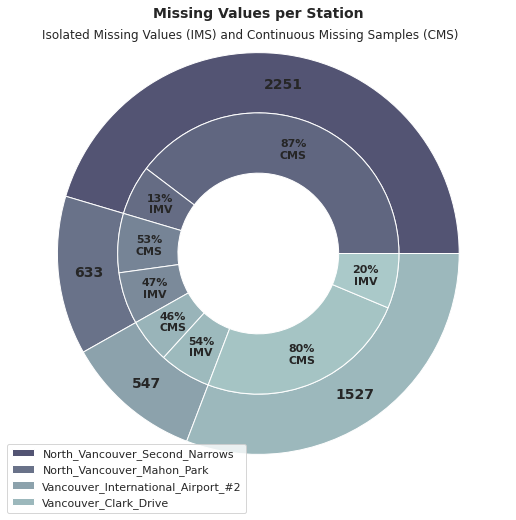

In [17]:
# Continuous missing samples // Isolated missing values count
stations = []
tot_missing = []
stations_cms_imv = []
stations_cms_imv_label = []

for station in pd.unique(master_df['STATION']):
  stations.append(station)
  tot_missing_current = sum(master_df['MISSING'][master_df['STATION'] == station])
  tot_missing.append(tot_missing_current)
  tot_cms = sum(master_df['MISSING_SAMPLE'][master_df['STATION'] == station])
  stations_cms_imv.append(tot_cms)
  stations_cms_imv_label.append(f'{tot_cms/tot_missing_current * 100:.0f}%\nCMS')
  tot_imv = tot_missing_current - tot_cms
  stations_cms_imv.append(tot_imv)
  stations_cms_imv_label.append(f'{tot_imv/tot_missing_current * 100:.0f}%\nIMV')

# Stacked pie charts with IMV and CMS percentages
fig, ax = plt.subplots(figsize = (9, 9))
ax.axis('equal')
width = 0.3

cm = plt.get_cmap("bone")
cout = cm([95, 120, 160, 178])
pie, texts1 = ax.pie(tot_missing, radius = 1, labels = tot_missing, colors = cout,
                labeldistance = 0.85, textprops = {'fontsize': 14, 'weight': 'bold'})
for t in texts1:
  t.set_horizontalalignment('center')
plt.legend(pie, stations, loc= (0, -0.03))
plt.setp(pie, width = width, edgecolor = 'white')

cin = cm(np.array([110, 115, 135, 140, 175, 180, 188, 193]))
pie2, texts2 = ax.pie(stations_cms_imv, radius = 1 - width, labels = stations_cms_imv_label,
                 labeldistance = 0.78, colors = cin, textprops = {'weight': 'bold'})
for t in texts2:
  t.set_horizontalalignment('center')
plt.setp(pie2, width = width, edgecolor = 'white')
plt.title('Missing Values per Station', fontsize = 14, weight = 'bold', y = 0.97)
plt.suptitle('Isolated Missing Values (IMS) and Continuous Missing Samples (CMS)',
             fontsize = 12, y = 0.85)
plt.show()

## Imputation of Missing Values
* IMV imputation with one-dimensional interpolation
* CMS imputation with LSTM

In [18]:
# Missing value subset for prediction
subset = master_df[(master_df['DATE_PST'] >= datetime(2016, 3, 9, 18)) &
                   (master_df['DATE_PST'] <= datetime(2016, 4, 9, 18)) &
                   (master_df['STATION'] == 'North_Vancouver_Mahon_Park')]

In [19]:
missing_interval = subset[subset['MISSING'] == 1]
len(missing_interval)

14

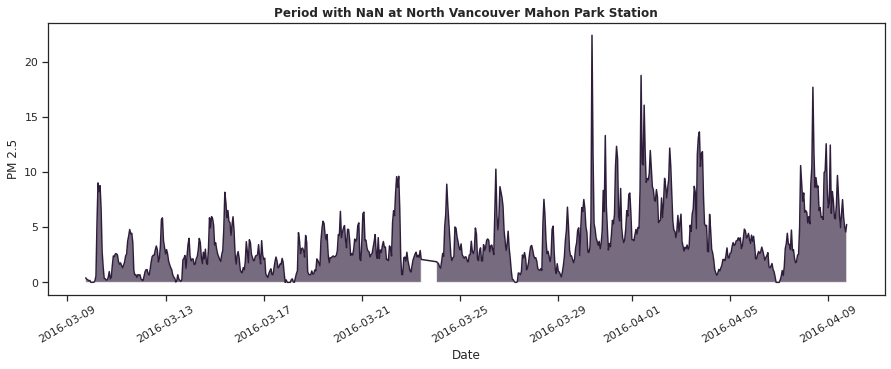

In [20]:
# Standard visualization with seaborn lineplot
plt.figure(figsize = (15, 5))

# Lineplot
l = sns.lineplot(x = 'DATE_PST', y = 'RAW_VALUE', data = subset)
# Filling values to indicate NaN
l.fill_between(x = 'DATE_PST', y1 = 'RAW_VALUE', data = subset, alpha = 0.65)
l.set_title("Period with NaN at North Vancouver Mahon Park Station",
            fontsize = 12, fontweight = 'bold')
l.set_ylabel("PM 2.5")
l.set_xlabel("Date")
plt.xticks(rotation = 30)
plt.show()

In [21]:
!pip -qq install darts

     |████████████████████████████████| 424 kB 35.5 MB/s 
     |████████████████████████████████| 1.8 MB 55.0 MB/s 
     |████████████████████████████████| 44 kB 2.1 MB/s 
     |████████████████████████████████| 708 kB 61.5 MB/s 
     |████████████████████████████████| 76.8 MB 1.2 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 11.2 MB 62.5 MB/s 
     |████████████████████████████████| 9.8 MB 71.0 MB/s 
     |████████████████████████████████| 1.6 MB 74.8 MB/s 
     |████████████████████████████████| 959 kB 59.1 MB/s 
     |████████████████████████████████| 419 kB 45.8 MB/s 
     |████████████████████████████████| 5.9 MB 65.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.1 which is incompatible.


In [22]:
from darts import TimeSeries
from darts.models import ExponentialSmoothing

series = TimeSeries.from_dataframe(subset, 'DATE_PST', 'RAW_VALUE')

In [23]:
# Training on 15 days prior to missing interval
# Validating on 15 after missing interval
train, val = series[0:min(missing_interval.index) - min(subset.index)], series[max(missing_interval.index) - min(subset.index):]

In [24]:
model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples = 1000)

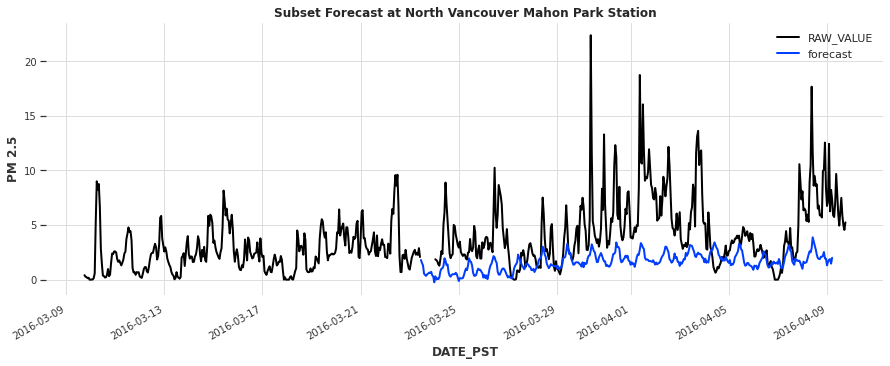

In [25]:
plt.figure(figsize = (15, 5))
series.plot()
prediction.plot(label='forecast', low_quantile=None, high_quantile=None)
plt.title("Subset Forecast at North Vancouver Mahon Park Station",
            fontsize = 12, fontweight = 'bold')
plt.ylabel("PM 2.5")
plt.legend()
plt.show()

In [26]:
def subset_interval(data = None,
                    time = 'DATE_PST',
                    value = 'RAW_VALUE',
                    column_type_missing = 'MISSING_SAMPLE',
                    column_missing = 'MISSING',
                    column_missing_sequence = 'MISSING_SEQ',
                    missing_type = None,
                    sequence_no = 0,
                    days_prior = 5,
                    days_later = 5,
                    verbose = True):
  '''
  Subset timeseries interval around an Individual Missing Value (IMV) or
  a Continuous Missing Sample (CMS):
  data: Pandas DataFrame with a time series and a value column.
  time: DateTime variable in the dataset.
  value: Value variable or list of variables to subset with date column.
  column_type_missing: Variable that stores missing value type.
  column_missing: Dummy variable that stores missing value indicator.
  column_missing_sequence: Variable that stores length of current missing sequence.
  missing_type: Type of missing value to search for. Either 'IMV' or 'CMS'.
  sequence_no: Which missing interval to use in the sequence of missing_type found.
  days_prior: Amount of days to subset prior to the missing_type interval.
  days_later: Amount of days to subsat after the missing_type interval.
  ''' 
  # Subsetting to missing values
  if missing_type == 'IMV':
    subset = data[data[column_type_missing] == 0]
    subset = subset[subset[column_missing] == 1]
  elif missing_type == 'CMS':
    subset = data[data[column_type_missing] == 1]
  else:
    return "Invalid or non-defined value type! Please select between: 'IMV' or 'CMS'"
    
  # Initializing start and end intervals, indices, star, and end lists
  start = min(subset[time])
  end = 0
  indices = []
  start_list = []
  end_list = []

  # Defining time deltas
  for i, row in subset.iterrows():
    try:
      td = i - indices[-1]
    except IndexError:
      # Initialize to 0 at the beginning of the subset iteration
      td = 0
    indices.append(i)
  
    # Set end date for the first missing sequence in the subset
    if not end:
      end = start + timedelta(hours = row[column_missing_sequence])
    
    # Storing start and end date when time delta > 1
    if td > 1:
      start = row[time]
      end = start + timedelta(hours = row[column_missing_sequence])
    
    # Appending start and end date for newly found sequences
    if start not in start_list:
      start_list.append(start)
    if end not in end_list:
      end_list.append(end)

  # Printing start and end lists for sequence sizes
  length = []
  for end, start in zip(end_list, start_list):
    length.append(str(int((end - start).days*24 + (end - start).seconds/3600)) + ' h')
  sequences_df = pd.DataFrame({'Sequence Start': start_list, 'Sequence End': end_list, 'Length': length})
  if verbose:
    print("Missing value sequences found with current argument:")
    print(tabulate(sequences_df, headers = 'keys', tablefmt = 'psql'), '\n')

  # Sequence to return
  start_date = start_list[sequence_no]
  end_date = end_list[sequence_no]
  start_date_exp = start_date - timedelta(days = days_prior)  
  end_date_exp = end_date + timedelta(days = days_later)

  # Checking for end date falling within a missing sequence
  if (end_date_exp >= start_list[sequence_no + 1]) and (end_date_exp <= end_list[sequence_no + 1]):
    if verbose:
      print("WARNING: Sequence ending on a missing interval. Expanding to incorporate next sequence")
    end_date = end_list[sequence_no + 1]
    end_date_exp = end_date + timedelta(days = days_later)
  
  # Checking for start date falling within a missing sequence
  try:
    if (start_date_exp >= start_list[sequence_no - 1]) and (start_date_exp <= end_list[sequence_no - 1]):
      if verbose:
        print("WARNING: Sequence starting on a missing interval. Expanding to incorporate previous sequence...")
      start_date = start_list[sequence_no - 1]
      start_date_exp = start_date - timedelta(days = days_prior)
  except IndexError:
    pass

  else:
    if verbose:
      print(f"Returning interval for first matched missing sequence: {(str(start_date), str(end_date))}")
      missing_tot = sum(subset[value][(subset[time] >= start_date_exp) & (subset[time] <= end_date_exp)].isna())
      print(f"Sum of missing sequence(s) length(s): {missing_tot} hours")

  if start_date_exp < min(subset[time]):
    if verbose:
      print(f"WARNING: Sequence start exceeds subset limit. Truncating to subset start date...")
    start_date_exp = min(subset[time]) - timedelta(days = days_prior)
  if end_date_exp > max(subset[time]):
    if verbose:
      print(f"WARNING: Sequence end exceeds subset limit. Truncating to subset end date...")
    end_date_exp = max(subset[time]) + timedelta(days = days_later)
  
  if verbose:
    print(f"Final interval{(str(start_date_exp), str(end_date_exp))}")
  
  return (start_date_exp, end_date_exp)

In [27]:
def plot_sequence(data = None,
                  time = 'DATE_PST',
                  value = 'RAW_VALUE',
                  start = None,
                  end = None,
                  y_label = 'PM 2.5',
                  x_label = 'Date',
                  x_rotate = 30,
                  plot_title = None,
                  plot_sup_title = None,
                  font_size = 12,
                  figsize = (15, 5)):
  '''
  Plot times series subset within passed start and end date interval.
  data: Pandas DataFrame with a time series and a value column.
  time: DateTime variable in the dataset.
  value: Value variable or list of variables to subset with date column.
  start: Start date for interval.
  end: End date for interval.
  y_label: Plot label for Y axis.
  x_label: Plot label for X axis.
  x_rotate: Rotation angle for X axis ticks.
  plot_title: Plot title.
  plot_sup_title: Plot sub-title.
  font_size: Plot tile font size.
  figsize: Plot canvas size.
  '''
  if start is None:
    start = min(data[time])
  if end is None:
    end = max(data[time])

  # Standard visualization with seaborn lineplot
  plt.figure(figsize = figsize)

  # Interval to plot
  if start <= min(data[time]):
    print("WARNING: Plot start exceeds subset limit. Truncating to subset start date...")
    start = min(data[time])
  if end >= max(data[time]):
    print("WARNING: Plot end exceeds subset limit. Truncating to subset end date...")
    end = max(data[time])
  subset = data[(data[time] >= start) & (data[time] <= end)]

  # Title and subtitle
  if plot_title is None:
    plot_title = f"Time Series sequence for {y_label}"
  if plot_sup_title is None:
    plot_sup_title = f"From {start:%H %p}, {start:%d-%b-%Y} to {end:%H %p}, {end:%d-%b-%Y}"

  # Lineplot
  l = sns.lineplot(x = time, y = value, data = subset)
  # Filling values to indicate NaN
  l.fill_between(x = time, y1 = value, data = subset, alpha = 0.65)

  l.set_title(plot_title, y = 1.05, fontsize = font_size, fontweight = 'bold')
  l.set_ylabel(y_label)
  l.set_xlabel(x_label)
  plt.suptitle(plot_sup_title, y = 0.92, fontsize = 12)
  plt.xticks(rotation = x_rotate)
  plt.show()

In [28]:
stations

['North_Vancouver_Second_Narrows',
 'North_Vancouver_Mahon_Park',
 'Vancouver_International_Airport_#2',
 'Vancouver_Clark_Drive']

In [29]:
station_subset = master_df[master_df['STATION'] == 'North_Vancouver_Mahon_Park']
interval = subset_interval(station_subset, missing_type = 'CMS', sequence_no = 11)

Missing value sequences found with current argument:
+----+---------------------+---------------------+----------+
|    | Sequence Start      | Sequence End        | Length   |
|----+---------------------+---------------------+----------|
|  0 | 2016-03-23 11:00:00 | 2016-03-24 01:00:00 | 14 h     |
|  1 | 2016-07-26 11:00:00 | 2016-07-27 00:00:00 | 13 h     |
|  2 | 2016-08-17 11:00:00 | 2016-08-18 14:00:00 | 27 h     |
|  3 | 2017-05-12 05:00:00 | 2017-05-14 19:00:00 | 62 h     |
|  4 | 2017-05-17 13:00:00 | 2017-05-18 12:00:00 | 23 h     |
|  5 | 2017-07-07 19:00:00 | 2017-07-08 10:00:00 | 15 h     |
|  6 | 2017-09-13 14:00:00 | 2017-09-13 21:00:00 | 7 h      |
|  7 | 2018-06-23 04:00:00 | 2018-06-23 13:00:00 | 9 h      |
|  8 | 2018-11-04 15:00:00 | 2018-11-05 03:00:00 | 12 h     |
|  9 | 2019-03-10 07:00:00 | 2019-03-10 15:00:00 | 8 h      |
| 10 | 2019-05-27 14:00:00 | 2019-05-28 05:00:00 | 15 h     |
| 11 | 2019-07-03 08:00:00 | 2019-07-05 00:00:00 | 40 h     |
| 12 | 2019-07-17

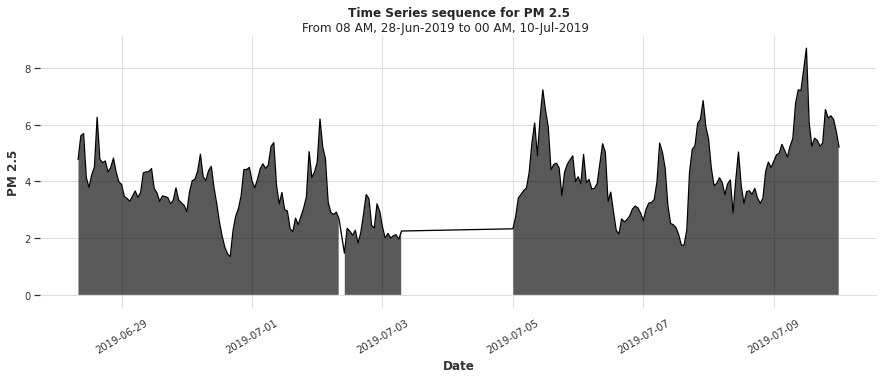

In [30]:
plot_sequence(data = station_subset, start = interval[0], end = interval[1])